In [24]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Inroduction


### Importing Libraries

In [25]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', color_codes=True)

import os
import datetime
# import pydot
import tensorflow as tf
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import plot_model
from keras.models import Sequential
from keras.regularizers import l1_l2
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix
#from src import plots
from matplotlib.pyplot import *
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# set random seed to 42 which is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)

## Defining the Functions

In [27]:
# Function to create a dictionary of model's train, validation and test results

def store_results_to_dict(model, model_description):
    from sklearn.metrics import precision_score, recall_score, f1_score
    train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
    val_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)   
    train_loss, train_acc = model.evaluate_generator(train_generator, steps=train_steps_per_epoch)
    val_loss, val_acc = model.evaluate_generator(val_generator, steps=val_steps_per_epoch)
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_steps_per_epoch)
    pred = model.predict_generator(test_generator, test_steps_per_epoch)
    pred_classes = np.round(pred)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    precision_score = precision_score(true_classes, pred_classes)
    recall_score = recall_score(true_classes, pred_classes)
    f1_score = f1_score(true_classes, pred_classes)
    curr_dict = { 'Model':model_description
                 ,'Train Accuracy': round(train_acc, 4)
                 ,'Train Loss': round(train_loss, 4)
                 ,'Validation Accuracy':round(val_acc, 4)
                 ,'validation Loss':round(val_loss, 4)
                 ,'Test Accuracy':round(test_acc, 4)
                 ,'Test Loss':round(test_loss, 4)
                 ,'Precision':round(precision_score, 4)
                 ,'Recall':round(recall_score, 4)
                 ,'f1':round(f1_score, 4)
                  }
    return curr_dict

In [28]:
# Function to plot the accuracy and loss of the model
def plot_acc_and_loss(model_history):
  acc = model_history.history['acc']
  val_acc = model_history.history['val_acc']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(figsize=(16,7))
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy',fontsize=20 )
  plt.legend()
  plt.figure(figsize=(16,7))
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and validation loss', fontsize=20)
  plt.legend()
  plt.show()

## About the data

3297 total skin lesion images from ISIC-Archive(https://www.isic-archive.com/#!/topWithHeader/wideContentTop/main) are used in the model. The files at 
 https://www.kaggle.com/fanconic/skin-cancer-malignant-vs-benign are uploaded. 

A validation set is made from the images to train the model at each epoch. 


### Directories

In [29]:
# train, test and validation directories of melanoma images 
train_data_dir=('/content/drive/My Drive/melanoma_image_classification/data/train')
val_data_dir=('/content/drive/My Drive/melanoma_image_classification/data/val')
test_data_dir=('/content/drive/My Drive/melanoma_image_classification/data/test')

### Numbers of Train, Test and Validation Images

In [30]:
# counting number of benign images and malignant images in each dataset of training, testing and validation
path='/content/drive/My Drive/melanoma_image_classification/data/'
# Numbers of benign and malignant images in each set
for folder in ['train', 'val', 'test']:
    
    n_malignant = len(os.listdir(path + folder + '/malignant'))
    n_benign = len(os.listdir(path + folder + '/benign'))
    
    print("There are {} benign skin images and {} malignant skin images in {} set. ".format(n_benign, n_malignant, folder))

There are 1192 benign skin images and 949 malignant skin images in train set. 
There are 248 benign skin images and 248 malignant skin images in val set. 
There are 360 benign skin images and 300 malignant skin images in test set. 


In [31]:
total_images_train_benign = os.listdir(path + 'train/benign')
total_images_train_malignant = os.listdir(path + 'train/malignant')

total_images_test_benign = os.listdir(path + 'test/benign')
total_images_test_malignant = os.listdir(path + 'test/malignant')

total_images_val_benign = os.listdir(path + 'val/benign')
total_images_val_malignant = os.listdir(path + 'val/malignant')

### Visualization of distributions

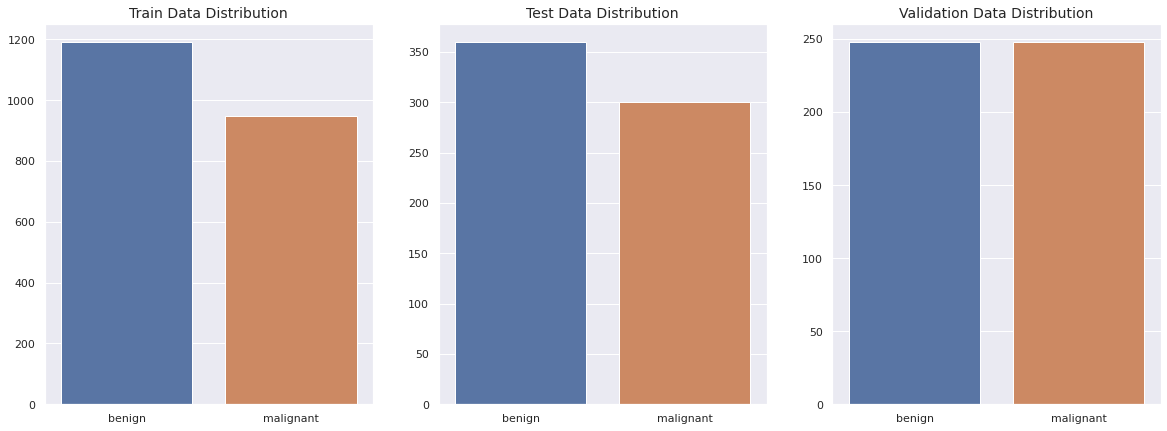

In [32]:
# plot shows the number of normal images versus pneumonia images in Train, Val and test set
plt.figure(figsize=(20, 7))
plt.subplot(131)
plt.title('Train Data Distribution', fontsize=14)
sns.barplot(x=['benign','malignant'],y=[len(total_images_train_benign),len(total_images_train_malignant)])
plt.subplot(132)
plt.title('Test Data Distribution', fontsize=14)
sns.barplot(x=['benign','malignant'],y=[len(total_images_test_benign),len(total_images_test_malignant)])
plt.subplot(133)
plt.title('Validation Data Distribution', fontsize=14)
sns.barplot(x=['benign','malignant'],y=[len(total_images_val_benign),len(total_images_val_malignant)])
plt.show()


### Display Images

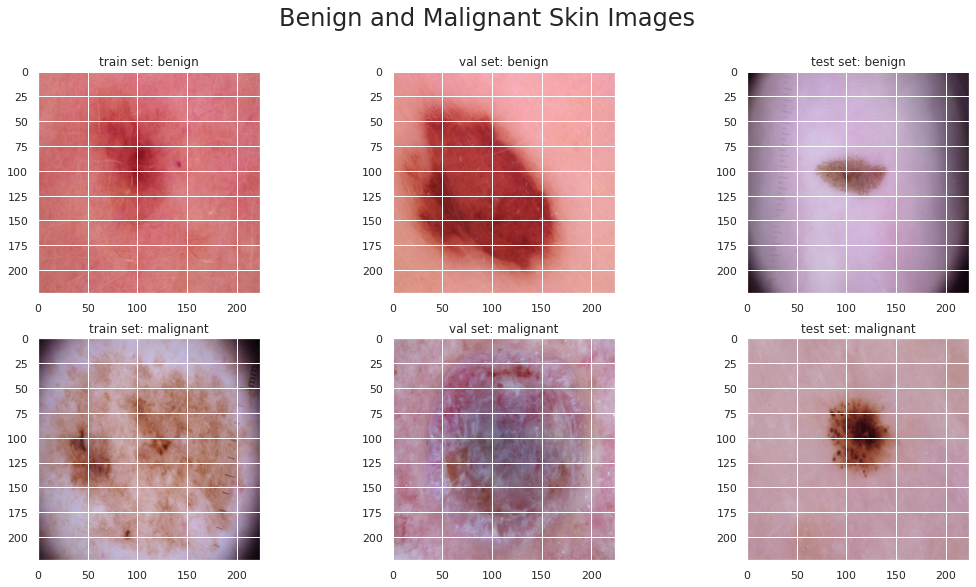

In [33]:
# displaying normal x-ray images and pneumonia x-ray images in train, test and val using imshow,imread
fig, ax = plt.subplots(2, 3, figsize=(18, 9))
ax = ax.ravel()

fig.suptitle('Benign and Malignant Skin Images', fontsize=24)

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = path+_set
    ax[i].imshow(plt.imread(set_path+'/benign/'+os.listdir(set_path+'/benign')[0]), cmap='gray')
    ax[i].set_title('{} set: benign'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/malignant/'+os.listdir(set_path+'/malignant')[0]), cmap='gray')
    ax[i+3].set_title('{} set: malignant'.format(_set))

### Define generators

In [34]:
# Get all the data in the directory DATA/TRAIN, and reshape them
print("Train data:")
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_data_dir,
                                                                         target_size=(150, 150), batch_size=32, class_mode='binary')

# Get all the data in the directory DATA/TEST , and reshape them    
print("Test data:")                                                                  
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_data_dir,
                                                                        target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)

# Get all the data in the directory DATA/VAL, and reshape them
print("Validation data:")  
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_data_dir,
                                                                       target_size=(150, 150), batch_size=32, class_mode='binary')

Train data:
Found 2141 images belonging to 2 classes.
Test data:
Found 660 images belonging to 2 classes.
Validation data:
Found 496 images belonging to 2 classes.


### Calculate the step size per epoch

In [35]:
# counting the stepsize per epoch
train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
val_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

### Define the parameters 

In [36]:
# Define the parameters of image transformation
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40, # rotating from -40 to40 degree
                               	width_shift_range=0.2, # allowing image generator to shift our images left or right  about 20% of total width
                               	height_shift_range=0.2,#allowing image generator to shift our images up or dowm  about 20% of total height
                               	shear_range=0.2,
                      	         zoom_range=0.2,
                               	horizontal_flip=True,
                               	fill_mode='nearest')
 
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
    	# This is the target directory
    	train_data_dir,
    	# All images will be resized to 150x150
    	target_size=(150, 150),
    	batch_size=32,
    	# Since we use binary_crossentropy loss, we need binary labels
    	class_mode='binary')
 
val_generator = test_datagen.flow_from_directory(val_data_dir,
                                                    	target_size=(150, 150),
     	                                               batch_size=32,
                                                    	class_mode='binary')

Found 2141 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


### VGG16 Model

In [37]:
conv_base = VGG16(weights='imagenet',#imagenet is the final weight of vgg16 
                  include_top=False, #meaning we will import only the conv base not the whole thing
                  input_shape=(150,150,3))

In [38]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [39]:
model1=Sequential()
model1.add(conv_base) #adding conv_base that was imported
model1.add(Flatten())
model1.add(Dense(256,activation='relu'))#adding fully connected dense layer with 256 neurons
model1.add(Dense(1,activation='sigmoid')) # output layer with single neuron

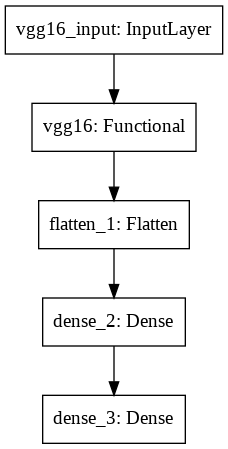

In [40]:
#structure of model1
plot_model(model1)
# looking at the structure of my neural network

### Compile and train the model

In [41]:
model1.compile(loss='binary_crossentropy',
          	optimizer=RMSprop(lr=2e-5),# small learning rate used because weights already optimized
          	metrics=['acc'])

In [42]:
# set random seed to 42 to is used to replicate the same result everytime , the output will be same if i run the cell in future
np.random.seed(42)
tf.random.set_seed(42)
# ⏰ This cell may take several minutes to run

start = datetime.datetime.now()
history = model1.fit_generator(train_generator,
                          	steps_per_epoch=train_steps_per_epoch,
                          	epochs=23,
                          	validation_data=val_generator,
                          	validation_steps=val_steps_per_epoch)
 
end = datetime.datetime.now()
elapsed = end - start 
print('---------Elapsed Time-----------')
print('Time to fit the VGG16 model is:\n {}'.format(elapsed))

Epoch 1/23
67/67 [==============================] - 24s 359ms/step - loss: 0.4692 - acc: 0.7753 - val_loss: 0.3795 - val_acc: 0.8125
Epoch 2/23
67/67 [==============================] - 24s 360ms/step - loss: 0.3615 - acc: 0.8202 - val_loss: 0.4405 - val_acc: 0.7823
Epoch 3/23
67/67 [==============================] - 24s 358ms/step - loss: 0.3240 - acc: 0.8538 - val_loss: 0.3847 - val_acc: 0.8125
Epoch 4/23
67/67 [==============================] - 24s 356ms/step - loss: 0.3112 - acc: 0.8566 - val_loss: 0.3394 - val_acc: 0.8387
Epoch 5/23
67/67 [==============================] - 24s 356ms/step - loss: 0.2850 - acc: 0.8627 - val_loss: 0.4044 - val_acc: 0.8085
Epoch 6/23
67/67 [==============================] - 24s 355ms/step - loss: 0.2722 - acc: 0.8716 - val_loss: 0.4397 - val_acc: 0.7782
Epoch 7/23
67/67 [==============================] - 23s 350ms/step - loss: 0.2584 - acc: 0.8814 - val_loss: 0.5426 - val_acc: 0.7177
Epoch 8/23
67/67 [==============================] - 24s 356ms/step - 

### Store the results

In [43]:
results=store_results_to_dict(model1, 'Base Model(with 4 conv,pooling layers,and dense full conv layer)')
results_final = []
# appending the results of the new model
results_final.append(results)
# putting the results in dataframe
df_model_results = pd.DataFrame(results_final)
df_model_results

,Model,Train Accuracy,Train Loss,Validation Accuracy,validation Loss,Test Accuracy,Test Loss,Precision,Recall,f1
0,"Base Model(with 4 conv,pooling layers,and dens...",0.9589,0.1062,0.8044,0.4531,0.8652,0.3606,0.8754,0.82,0.8468


### Plot the results

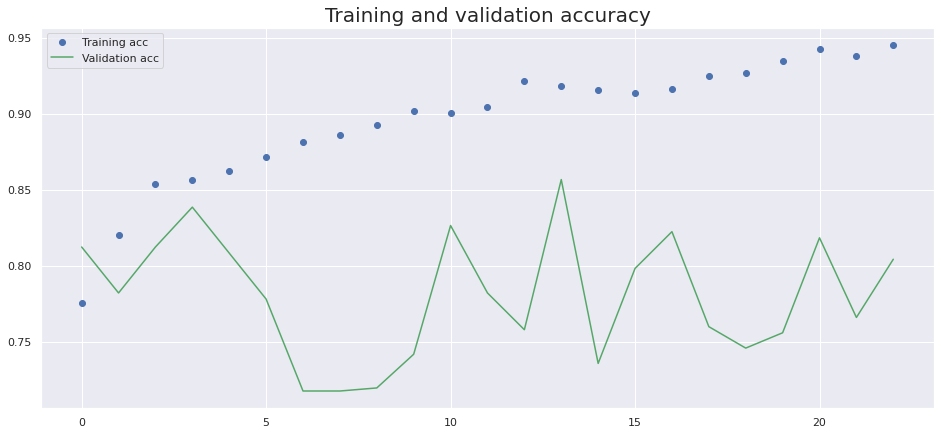

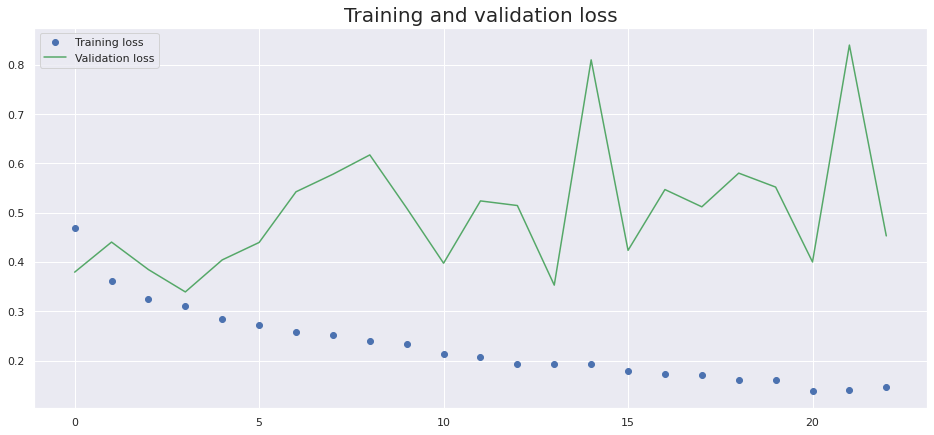

In [44]:
plot_acc_and_loss(history)

### Prediction results on the test set

We got 87% accuracy in classifying benign and malignant melanoma images.

In [45]:
pred = model1.predict_generator(test_generator, test_steps_per_epoch)
pred_classes = np.round(pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Baseline Model:\n")
print("Confusion Matrix:\n", confusion_matrix(true_classes, pred_classes))
print("----------------------------------------------------")
print("Classification Report:\n", classification_report(true_classes, pred_classes, target_names=class_labels))

Baseline Model:

Confusion Matrix:
 [[325  35]
 [ 54 246]]
----------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

      benign       0.86      0.90      0.88       360
   malignant       0.88      0.82      0.85       300

    accuracy                           0.87       660
   macro avg       0.87      0.86      0.86       660
weighted avg       0.87      0.87      0.86       660



### Conclusion

In this project, we classified the melanoma images as beningn and malignant. As for NF patients we are able to make a smaller classification model and classify, segment and track the skin lessions when we get the image data. 